# Data Preprocessing

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import xml.etree.ElementTree as ET
import glob
import pandas as pd
import os


# Initialize empty lists to store the extracted values
elaborated_types = []
center_x_values = []
center_y_values = []
image_paths = []
border_x_values = []
border_y_values = []
head_x_values = []
head_y_values = []
tail_x_values = []
tail_y_values = []





def sortdata(main_directory):


  for folder in os.listdir(main_directory):

    global elaborated_types
    global center_x_values
    global center_y_values
    global image_paths
    global border_x_values
    global border_y_values
    global head_x_values
    global head_y_values
    global tail_x_values
    global tail_y_values


    images_directory = os.path.join(main_directory, folder, folder, 'Patch')
    xml_file_path = os.path.join(main_directory, folder, folder, 'Ship.xml')

    # List all XML files in the directory
    images = glob.glob(f'{images_directory}/*.tif')

    # Parse the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Iterate through each <Ship> tag
    for ship in root.iter('ship'):
        # Extract values from the child elements
        elaborated_type = ship.find('MarineTrafficInformation/Elaborated_type').text
        head_x = int(ship.find('SARShipInformation/Head_x').text)
        head_y = int(ship.find('SARShipInformation/Head_y').text)
        tail_x = int(ship.find('SARShipInformation/Tail_x').text)
        tail_y = int(ship.find('SARShipInformation/Tail_y').text)


        height = abs(head_x - tail_x)
        width = abs(head_y - tail_y)


        if (elaborated_type == 'Container Ship' or elaborated_type == 'Tanker' or elaborated_type == 'Bulk Carrier') and height <= 64 and width <= 64:
          center_x = ship.find('SARShipInformation/Center_x').text
          center_y = ship.find('SARShipInformation/Center_y').text

          # Append the values to the respective lists
          elaborated_types.append(elaborated_type)
          center_x_values.append(center_x)
          center_y_values.append(center_y)
          border_x = int(ship.find('SARShipInformation/LowerRight_x').text)
          border_y = int(ship.find('SARShipInformation/LowerRight_y').text)
          border_x_values.append(border_x)
          border_y_values.append(border_y)
          head_x_values.append(head_x)
          head_y_values.append(head_y)
          tail_x_values.append(tail_x)
          tail_y_values.append(tail_y)

          # match XML to image
          # Iterate through the files in the folder
          for filename in os.listdir(images_directory):
              file_path = os.path.join(images_directory, filename)

              # Check if the file is an image and contains both phrases
              if center_x in filename and center_y in filename:
                  image_paths.append(file_path)
                  break


main_directory = '/content/drive/MyDrive/OpenSARShip_1'
sortdata(main_directory)

# Create a DataFrame from the extracted values
data = {
    'path': image_paths,
    'elaborated_type': elaborated_types,
    'Center_x': center_x_values,
    'Center_y': center_y_values,
    'border_x': border_x_values,
    'border_y': border_y_values,
    'head_x': head_x_values,
    'head_y': head_y_values,
    'tail_x': tail_x_values,
    'tail_y': tail_y_values
}
df = pd.DataFrame(data)






In [ ]:
!pip install rasterio

In [ ]:
import rasterio
import numpy as np

In [ ]:
# Iterate through dataframe and process each image using rasterio


vv_arrays = []
bb_arrays = []



for index, row in df.iterrows():

  image_path = row['path']
  image = rasterio.open(image_path)
  image_arr = image.read()
  size = np.shape(image_arr)[1]

  if size >= 64:
    vv_arr = np.vectorize(complex)(image_arr[2], image_arr[3])

    # get bounding box coordinates
    bb1 = row['tail_x'] - row['border_x']
    bb2 = row['head_y'] - row['border_y']
    bb3 = row['head_x'] - row['border_x']
    bb4 = row['tail_y'] - row['border_y']


    xmin = min(bb1, bb3)
    xmax = max(bb1, bb3)
    ymin = min(bb2, bb4)
    ymax = max(bb2, bb4)


    if (ymax - ymin) <= 2:
      ymin = ymin - 4
      ymax = ymax + 4
    elif (ymax - ymin) <=3:
      ymin = ymin - 3
      ymax = ymax + 3


    bb = np.array([ymin, xmin, ymax, xmax])



    # create mask
    rows = vv_arr.shape[1]
    cols = vv_arr.shape[1]
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.


    # center crop image and bounding box mask

    def center_crop(im, w=64, h=64):
      center = im.shape
      x = center[1]/2 - w/2
      y = center[0]/2 - h/2
      cropped = im[int(y):int(y+h), int(x):int(x+w)]
      return cropped

    def mask_to_bb(Y):
      """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
      cols, rows = np.nonzero(Y)
      if len(cols)==0:
          return np.zeros(4, dtype=np.float32)
      top_row = np.min(rows)
      left_col = np.min(cols)
      bottom_row = np.max(rows)
      right_col = np.max(cols)
      return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


    x, Y = center_crop(vv_arr), center_crop(Y)
    Y = mask_to_bb(Y)
    vv_arrays.append(x)
    bb_arrays.append(Y)
    print(Y.dtype)



  else:
    vv_arrays.append(None)
    bb_arrays.append(None)




processed_data = pd.DataFrame({'vv_arr': vv_arrays, 'bb_array': bb_arrays})

# Concatenate the NumPy DataFrame to the original DataFrame
data_df = pd.concat([df, processed_data], axis=1)



In [ ]:
# Drop rows without vv_arr
data_df = data_df.dropna()


In [ ]:
print(data_df['elaborated_type'].value_counts())

Container Ship    405
Bulk Carrier      276
Tanker            128
Name: elaborated_type, dtype: int64


In [ ]:
import random

num_rows_to_drop = 223
num_rows_to_drop_2 = 136


# Filter rows where 'elaborated_type' is equal to 'Container Ship'
container_ship_rows = data_df[data_df['elaborated_type'] == 'Container Ship']
bulk_carrier_rows = data_df[data_df['elaborated_type'] == 'Bulk Carrier']


# Randomly select the rows to drop
rows_to_drop = random.sample(container_ship_rows.index.tolist(), num_rows_to_drop)
rows_to_drop_2 = random.sample(bulk_carrier_rows.index.tolist(), num_rows_to_drop_2)


# Drop the selected rows from the original dataframe
data_df.drop(rows_to_drop, inplace=True)
data_df.drop(rows_to_drop_2, inplace=True)

# Optional: Reset the index of the modified dataframe
data_df.reset_index(drop=True, inplace=True)

In [ ]:
print(data_df['elaborated_type'].value_counts())

Container Ship    182
Bulk Carrier      140
Tanker            128
Name: elaborated_type, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import os

file_paths = []
bb_arrays = []

# Iterate through the DataFrame
for index, row in data_df.iterrows():
    vv_arr = row['vv_arr']
    class_label = row['elaborated_type']
    bb = row['bb_array']

    # Create folder if it doesn't exist
    folder_path = os.path.join('.', class_label)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save VV_arr as .npy file
    file_path = os.path.join(folder_path, f'{index}.npy')

    file_paths.append(file_path)
    bb_arrays.append(bb)

    np.save(file_path, vv_arr)

boundingbox_df = pd.DataFrame({'path': file_paths, 'bb_array': bb_arrays})



In [ ]:
boundingbox_df.to_csv('boundingbox.csv', index=False)

In [ ]:
classes = {
    'Container Ship': 0,
    'Tanker': 1,
    'Bulk Carrier': 2,
}

with open('class_mapping.txt', 'w') as file:
    file.write("catename,label\n")
    for class_name, label in classes.items():
        file.write(f"{class_name},{label}\n")


In [ ]:
# Generate text file containing path and category

import os

root_directory = '/content'  # Replace with the path to your root directory

with open('file_paths_all.txt', 'w') as file:
    file.write("path,catename\n")

    # Iterate over subfolders in the root directory
    for folder_name in ['Container Ship', 'Bulk Carrier', 'Tanker']:
        folder_path = os.path.join(root_directory, folder_name)

        # Iterate over files in the subfolder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.npy'):
                file_path = os.path.join(folder_path, file_name)
                file.write(f"{file_path},{folder_name}\n")





In [ ]:

def gen_train_val(data_root, val_ratio, case):

    df_train = pd.DataFrame(columns=['path', 'catename'])
    df_val = pd.DataFrame(columns=['path', 'catename'])

    for cate in os.listdir(data_root):
        data_list = os.listdir(data_root + cate)
        random.shuffle(data_list)
        val_num = int(len(data_list) * val_ratio)
        for i, item in enumerate(data_list):
            if i < val_num:
                df_val.loc[len(df_val) + 1] = [cate + '/' + item, cate]
            else:
                df_train.loc[len(df_train) + 1] = [cate + '/' + item, cate]

    print(len(df_val), len(df_train))

    if case=="slc":
      df_train.to_csv('/content/slc_train.txt', index=False)
      df_val.to_csv('/content/slc_val.txt', index=False)
    else:
      df_train.to_csv('./cae_train.txt', index=False)
      df_val.to_csv('./cae_val.txt', index=False)

gen_train_val('/content/Classes/', val_ratio=0.08, case="spec")
gen_train_val('/content/Classes/', val_ratio=0.08, case="slc")







35 415
35 415


In [ ]:
!zip -r 'Classes.zip' '/content/Classes'



In [ ]:
from google.colab import files
files.download('Classes.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
testprev = np.load('predicted_bb_426.npy')
testprev = testprev.flatten()
print(testprev)

[27  4 34 53]


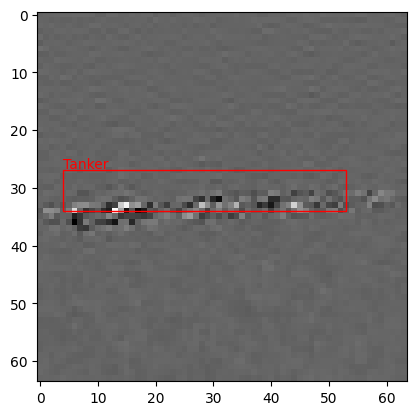

49


In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

def show_corner_bb(im, bb, label):
    fig, ax = plt.subplots()
    show(im, ax=ax, cmap='gray')
    rectangle = plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color='red',
                         fill=False, lw=1)
    ax.add_patch(rectangle)
    ax.text(bb[1], bb[0] - 0.5, label, color='r')
    plt.show()


im = np.load('426.npy')
im = np.imag(im)
bb = testprev
show_corner_bb(im, bb, label='Tanker')

print(bb[3]-bb[1])




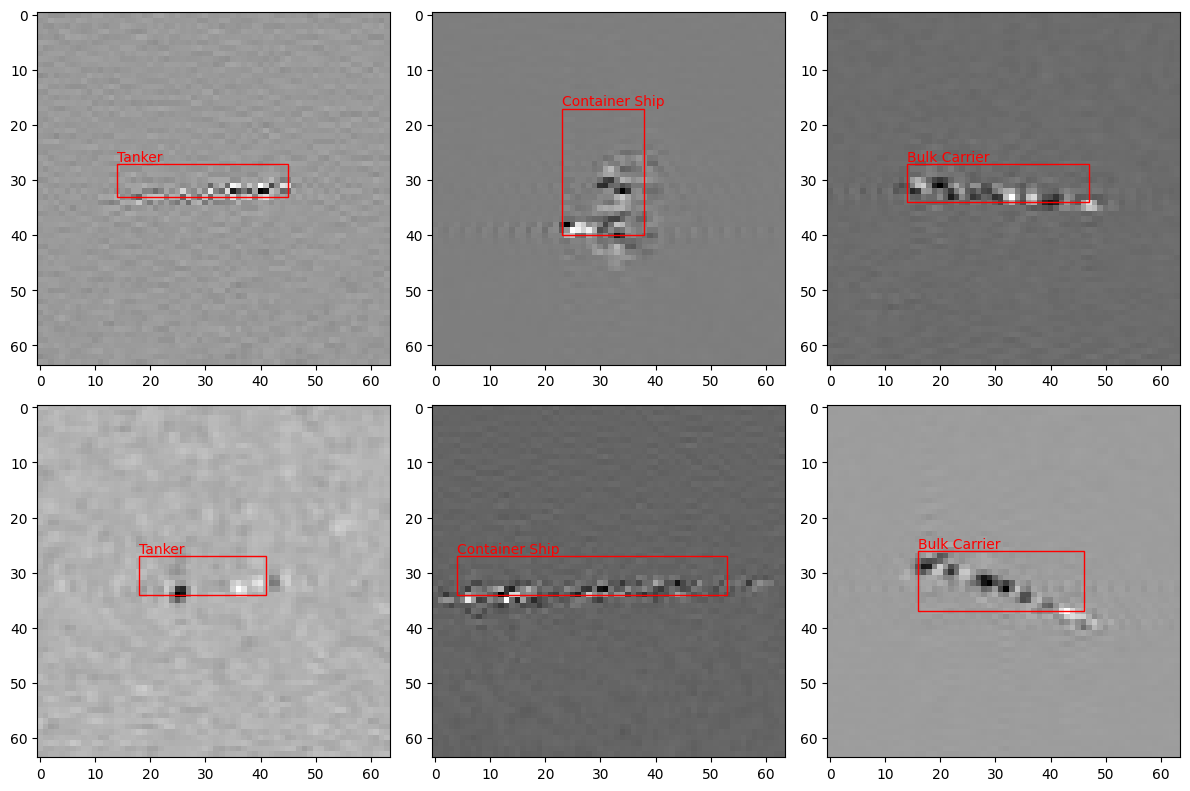

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

def show_corner_bb(im, bb, label, ax):
    show(im, ax=ax, cmap='gray')
    rectangle = plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color='red',
                              fill=False, lw=1)
    ax.add_patch(rectangle)
    ax.text(bb[1], bb[0] - 0.5, label, color='r')

# Assuming you have a list of image arrays and bounding boxes named 'image_arrays' and 'bb_arrays'
image_arrays = ['404.npy','203.npy','279.npy','442.npy','426.npy','285.npy']  # Your list of image arrays
bb_arrays = ['predicted_bb_404.npy','predicted_bb_203.npy','predicted_bb_279.npy','predicted_bb_442.npy','predicted_bb_426.npy','predicted_bb.npy']  # Your list of bounding boxes
labels = ['Tanker', 'Container Ship', 'Bulk Carrier', 'Tanker', 'Container Ship', 'Bulk Carrier']

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

# Plot the images with bounding boxes
for i in range(6):
    im = np.load(image_arrays[i])
    im = np.real(im)
    bb = np.load(bb_arrays[i])
    bb = bb.flatten()
    label = labels[i]
    show_corner_bb(im, bb, label, ax=axs[i])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()





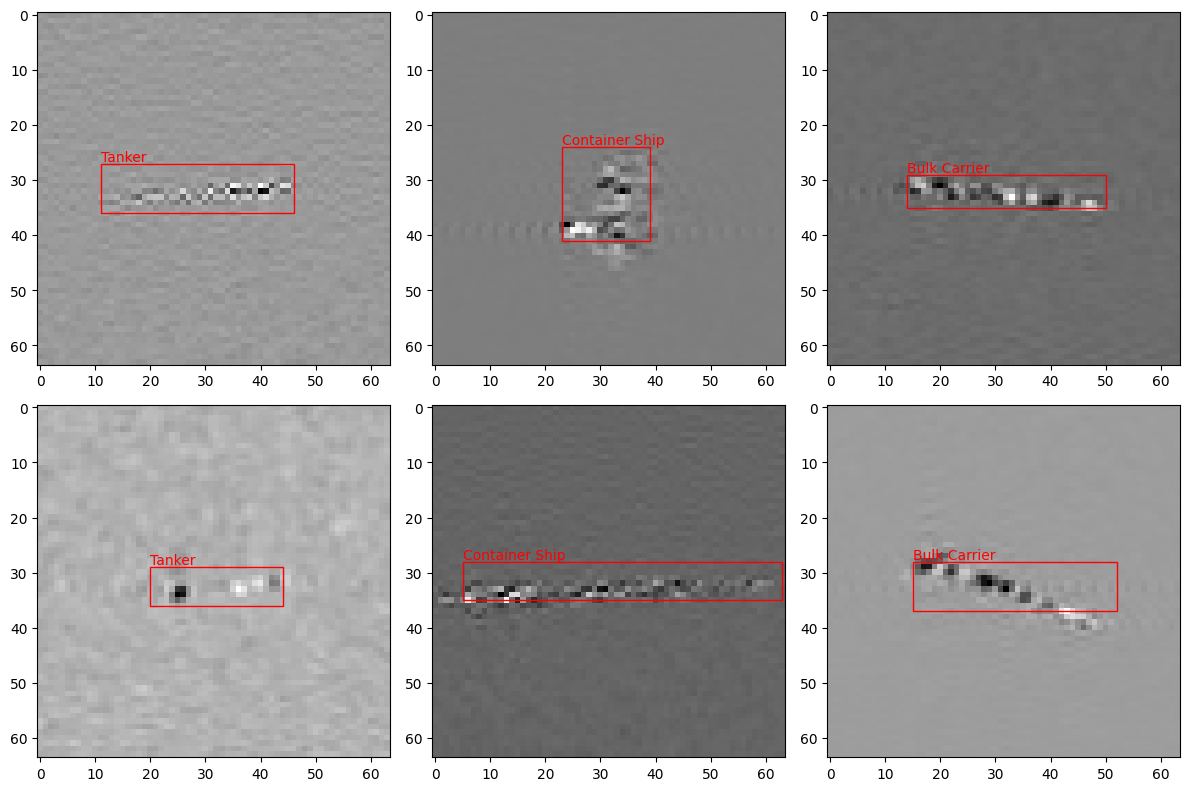

In [ ]:
# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()



row_indexes = [405, 204, 280, 443, 427, 286]

bbs = []

for row_index in row_indexes:
  bb = np.array(data_df.loc[row_index, 'bb_array'])
  bbs.append(bb)


image_arrays = ['404.npy','203.npy','279.npy','442.npy','426.npy','285.npy']  # Your list of image arrays
labels = ['Tanker', 'Container Ship', 'Bulk Carrier', 'Tanker', 'Container Ship', 'Bulk Carrier']




# Plot the images with bounding boxes
for i in range(6):
    im = np.load(image_arrays[i])
    im = np.real(im)
    bb = bbs[i]
    label = labels[i]
    show_corner_bb(im, bb, label, ax=axs[i])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
